#  Import packages

In [3]:
import numpy as np
import h5py
import glob
import re
import tensorflow as tf

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

np.set_printoptions(precision=3, suppress=True)

# Setup GPU

First, follow instructions [here](https://gist.github.com/zrruziev/b93e1292bf2ee39284f834ec7397ee9f), or alternatively run:
```bash
for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done
```
We do this as a workaround for [this error](https://github.com/tensorflow/tensorflow/issues/42738):

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
print(tf.config.list_physical_devices('GPU'), tf.test.gpu_device_name())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] /device:GPU:0


2024-02-14 11:45:56.336199: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 4188 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:07:00.0, compute capability: 7.5


# Import and prepare data

In [5]:
def extract_floats(string):
    return re.findall(r"[-+]?\d*\.\d+|\d+", string)

def data_load():
    density = 0.15
    files = glob.glob(f"../no_roll_data/dataset_tumble_*_{density}.h5")
    inputs,outputs = [],[]
    for f in files:
        tumble = float(extract_floats(f)[0])
        with h5py.File(f, "r") as fin:
          count = 0
          for key in fin.keys():
              img = fin[key][:]
              img = img.reshape((img.shape[0], img.shape[1],1))
              shape = img.shape
              inputs.append(img)
              outputs.append(tumble)
              count+=1

    # Scramble the dataset
    order = np.arange(len(outputs)).astype(int)
    order = np.random.permutation(order)
    return np.array(inputs)[order],np.array(outputs)[order],shape

In [7]:
x,y,shape = data_load()

In [8]:
print("Number of unique alpha: ", len(np.unique(y)))
print("Shape of x: ", np.shape(x))
print("Shape of y: ", np.shape(y))

Number of unique alpha:  10
Shape of x:  (10000, 128, 128, 1)
Shape of y:  (10000,)


We have 1000 * number of unique alpha snapshots total, we split them into a training set and a validation set:

In [9]:
last = 2000
x_train, y_train = x[:-last], y[:-last]
x_val,y_val = x[-last:],y[-last:]

print("Size of training data: ", len(x_train))
print("Size of validation data: ", len(x_val))

Size of training data:  8000
Size of validation data:  2000


# Setup and train our model

In [37]:
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPooling2D,BatchNormalization,AveragePooling2D,Normalization

Workaround for dropout not working:

In [38]:
import contextlib

@contextlib.contextmanager
def options(options):
  old_opts = tf.config.optimizer.get_experimental_options()
  tf.config.optimizer.set_experimental_options(options)
  try:
    yield
  finally:
    tf.config.optimizer.set_experimental_options(old_opts)

**Run this after analysis to reset model and release RAM before changing the architecture**

In [25]:
import gc

K.clear_session()
del prediction
del model
del history

print("Collected: ", gc.collect())

Collected:  90056


## Setting up the model's architecture

In [26]:
model = Sequential()

model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', strides=(3,3), activation='relu', input_shape=shape))
model.add(BatchNormalization())
model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', input_shape=shape))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(3, 3)))

#model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=6, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=6, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Dense(units=128, activation='relu'))

#with options({"layout_optimizer": False}):
#    model.add(Dropout(0.2))
#model.add(Dense(units=10, activation='softmax'))

model.add(Flatten())
model.add(Dense(units=1, activation='linear'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 43, 43, 3)         30        
                                                                 
 batch_normalization (BatchN  (None, 43, 43, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 43, 3)         84        
                                                                 
 batch_normalization_1 (Batc  (None, 43, 43, 3)        12        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 3)        0         
 )                                                               
                                                        

## Optimizer

In [28]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['accuracy'])

## Training and evaluation

Before training, these are the "predictions":

32/32 [==============================] - 0s 3ms/step
Shape of prediction :  (2000, 1)
Pearson's correlation coeff:  -0.0015064395327946648


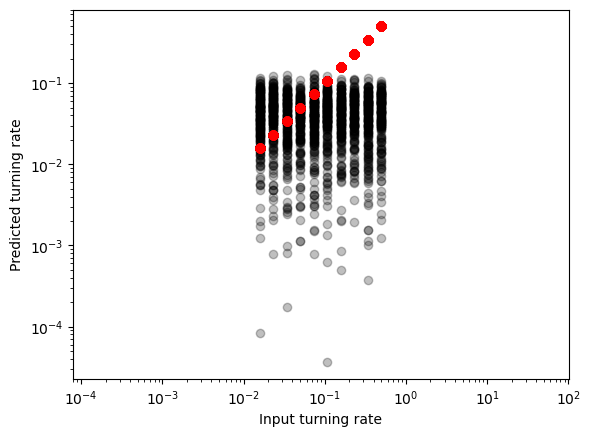

In [29]:
prediction = model.predict(x_val, batch_size=64)
print("Shape of prediction : ", np.shape(prediction))

plt.plot(y_val, prediction.T[0], 'o', c='k', alpha=0.25)
plt.plot(y_val, y_val, 'o', color='r')

print("Pearson's correlation coeff: ", pearsonr(y_val, prediction.T[0]).statistic)
plt.xlabel("Input turning rate")
plt.ylabel("Predicted turning rate")
plt.axis("equal")
plt.xscale("log")
plt.yscale("log")

Actual:  0.073
Predicted:  0.020957768


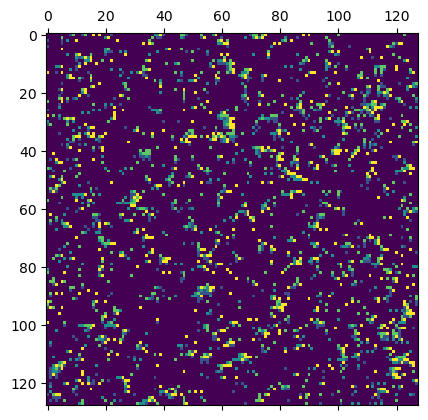

In [30]:
demo_idx = 100
plt.matshow(x_val[demo_idx])
print("Actual: ", y_val[demo_idx])
print("Predicted: ", prediction.T[0][demo_idx])

We can play with the architecture and see how the untrained predictions can change too.

## Run the training

In [31]:
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    verbose=True,
    batch_size=64,
    validation_data=(x_val, y_val)
)

Epoch 1/10


2024-02-14 11:53:01.733278: I external/local_xla/xla/service/service.cc:168] XLA service 0x7a10a77ccf50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-14 11:53:01.733299: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-02-14 11:53:01.755850: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707911581.879167    4695 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - 3s 7ms/step - loss: 0.1238 - accuracy: 0.0000e+00 - val_loss: 0.1388 - val_accuracy: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0800 - accuracy: 0.0000e+00 - val_loss: 0.1222 - val_accuracy: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0762 - accuracy: 0.0000e+00 - val_loss: 0.0796 - val_accuracy: 0.0000e+00
Epoch 4/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0626 - accuracy: 0.0000e+00 - val_loss: 0.0628 - val_accuracy: 0.0000e+00
Epoch 5/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0587 - accuracy: 0.0000e+00 - val_loss: 0.0629 - val_accuracy: 0.0000e+00
Epoch 6/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0540 - accuracy: 0.0000e+00 - val_loss: 0.0698 - val_accuracy: 0.0000e+00
Epoch 7/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0532 - accuracy: 0.0000e+00 - val_l

In [32]:
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=64, verbose=0)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

Evaluate on test data:
Test loss: 0.0445106066763401
Test accuracy: 0.0


# Alternatively, load a trained model

In [16]:
model = tf.keras.models.load_model('../models/with_dropout.keras')
model.summary()

2024-02-14 11:48:31.618875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4188 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:07:00.0, compute capability: 7.5
2024-02-14 11:48:31.618940: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 43, 43, 3)         30        
                                                                 
 batch_normalization (BatchN  (None, 43, 43, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 43, 3)         84        
                                                                 
 batch_normalization_1 (Batc  (None, 43, 43, 3)        12        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 3)        0         
 )                                                               
                                                        

# Analyse training results

In [33]:
prediction = model.predict(x_val, batch_size=64)
print("Shape of prediction : ", np.shape(prediction))

32/32 [==============================] - 0s 3ms/step
Shape of prediction :  (2000, 1)


Pearson's correlation coeff:  0.8977497030721596


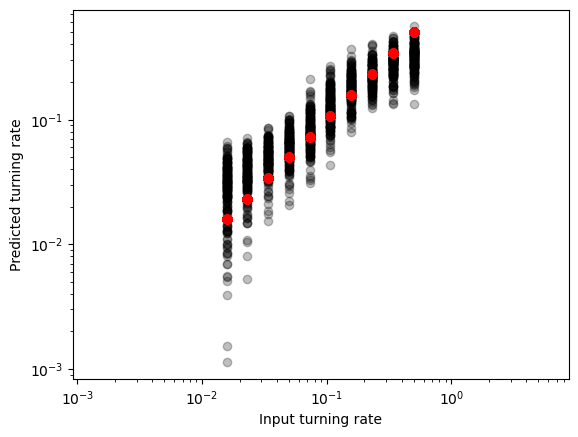

In [34]:
fig, ax = plt.subplots()
plt.plot(y_val, prediction.T[0], 'o', c='k', alpha=0.25)
plt.plot(y_val, y_val, 'o', color='r')

print("Pearson's correlation coeff: ", pearsonr(y_val, prediction.T[0]).statistic)
plt.xlabel("Input turning rate")
plt.ylabel("Predicted turning rate")
plt.axis("equal")
plt.xscale("log")
plt.yscale("log")

### Kernel analysis

3


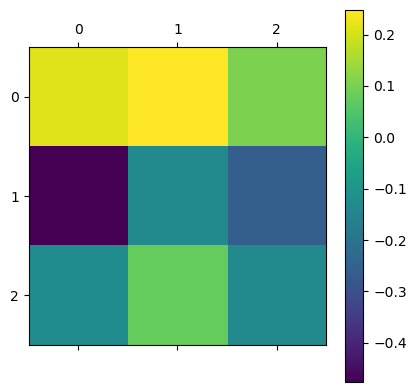

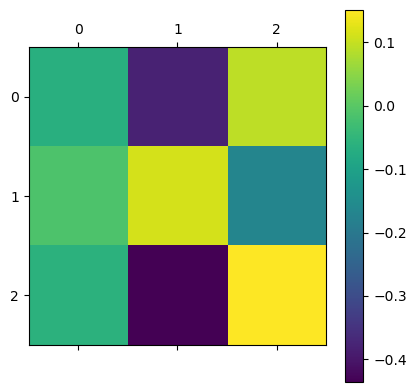

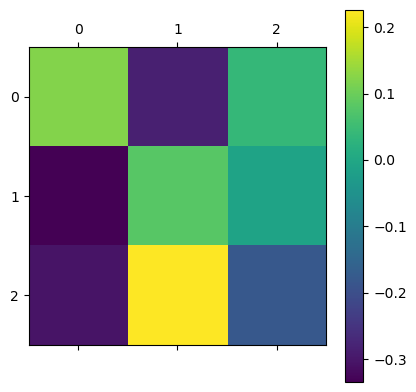

In [35]:
filters, biases = model.layers[0].get_weights()
print (filters.shape[-1])
for k in range(filters.shape[-1]):
  f = filters[:, :, :, k]
  plt.matshow(f.squeeze())
  plt.colorbar()

# Save model (if needed)

In [36]:
name = "without_dropout"
model.save(f"../models/{name}.keras")